# RMSLE
The evaluation metric for this competition is the Root Mean Square Log Error (RMSLE).

RMSLE is a measure that evaluates the difference between predicted and actual target values, taking into account the logarithm of these differences.

# STORE SALES -TIMES SERIES FORECASTING

This contest is about time series forecasting for store sales. The data comes from an Ecuadorian company known as Corporación Favorita and is a large grocery retailer. In addition, the company operates in other countries in South America..

If you wonder the company, you can click [**here**](https://www.corporacionfavorita.com/en/) to learn something about it.


This Notebook focuses on:
- Interpolation for Oil Prices
- Detailed Data Manipulation for Holiday and Events Data
- Exploratory Data Analysis
- Hypothesis Testing
- Modelling

There are **54 stores** and **33 product families** in the data. The time series starts on **2013-01-01** and ends on **2017-08-31**. However, Kaggle gives us two split data as training and test. The dates in the test data are for **15 days** after the last date in the training data. The date range in the test data will be very important as we define a cross validation strategy and create new features.

***Our main mission in this contest is to predict sales for each product family and store combination.***

There are 6 data we will study on them step by step.
1. *TRAIN
2. *TEST*
3. *STORES*
4. *TRANSACTIONS*
5. *HOLIDAYS AND EVENTS*
6. *OIL PRICE*

**<code>TRAIN</code>** contain time series of the combination of stores and product families. The sales column indicates the total sales of a product family in a given store on a given date. Fractional values are possible, since products can be sold in fractional units (1.5 kg of cheese, for example, versus 1 bag of potato chips).The on promotion column indicates the total number of items in a product family that were on promotion in a store on a given date.

**<code>STORES</code>** gives some information about the stores such as city, state, type, cluster.

**<code>TRANSACTIONS</code>** are highly correlated with the train sales column. Store sales patterns can be understood.

**<code>HOLIDAYS AND EVENTS</code>** is a metadata. This data is very valuable for understanding past sales, trend and seasonality components. However, it needs to be organized. You will find an exhaustive manipulation of this data. This part will be one of the most important chapters of this booklet.

**<code>OIL PRICE</code>** is another piece of information that will help us. Ecuador is an oil-dependent country and its economic health is very vulnerable to oil price fluctuations. Therefore, it will help us to understand which product families are positively or negatively affected by the price of oil.

#### When you look at the description of the data, you will see "Additional Notes". These notes may be significant in picking up some patterns or anomalies. I share them with you so that you will remember them.
- Public sector salaries are paid biweekly on the 15th and last day of the month. Supermarket sales could be affected.
- A 7.8 magnitude earthquake struck Ecuador on April 16, 2016. People mobilized in relief efforts by donating water and other necessities, which greatly affected supermarket sales for several weeks after the earthquake.

# BIBLIOTECAS
---

In [1]:
import plotly.express as px
from scipy.stats import f_oneway
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import calendar
import gc

# CARGA DE DATOS
---

In [2]:
train = pd.read_csv('data/train.csv')
holidays=pd.read_csv('data/holidays_events.csv')
oil=pd.read_csv('data/oil.csv')
stores=pd.read_csv('data/stores.csv')
transactions=pd.read_csv('data/transactions.csv')
test=pd.read_csv('data/test.csv')

In [3]:
train_ori = pd.read_csv('data/train.csv')
holidays_ori=pd.read_csv('data/holidays_events.csv')
oil_ori=pd.read_csv('data/oil.csv')
stores_ori=pd.read_csv('data/stores.csv')
transactions_ori=pd.read_csv('data/transactions.csv')
test_ori=pd.read_csv('data/test.csv')

# TRAIN
---
---

In [ ]:
## EXPLO

## Exploratory Analysis
---

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train.shape

(3000888, 6)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
train[["store_nbr","family","date",'onpromotion']].nunique()

store_nbr        54
family           33
date           1684
onpromotion     362
dtype: int64

In [ ]:
#Let's check how many times is appearing each family in the dataset
train[['family']].value_counts()

family                    
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
C

In [ ]:
#same case with the stores
train[['store_nbr']].value_counts().sort_index()

store_nbr
1            55572
2            55572
3            55572
4            55572
5            55572
6            55572
7            55572
8            55572
9            55572
10           55572
11           55572
12           55572
13           55572
14           55572
15           55572
16           55572
17           55572
18           55572
19           55572
20           55572
21           55572
22           55572
23           55572
24           55572
25           55572
26           55572
27           55572
28           55572
29           55572
30           55572
31           55572
32           55572
33           55572
34           55572
35           55572
36           55572
37           55572
38           55572
39           55572
40           55572
41           55572
42           55572
43           55572
44           55572
45           55572
46           55572
47           55572
48           55572
49           55572
50           55572
51           55572
52           55572
53

Valores NAN

In [ ]:
# Porcentaje de valores nulos para aquellas variables que tengan alguno
cols_con_na = train.columns[train.isnull().any()]
print(cols_con_na)
print("\n----------------------------\n")
print(f"{len(cols_con_na)} columnas de un total de {len(train.columns)} contienen datos nulos")
print("\n")
print("Porcentaje de valores nulos por variable:\n")
print(train[cols_con_na].isnull().mean()*100)

Index([], dtype='object')

----------------------------

0 columnas de un total de 6 contienen datos nulos


Porcentaje de valores nulos por variable:

Series([], dtype: float64)


### TRAIN First View
- Tenemos un amplio data set de 3M filas x 11 columnas
- el numero de valores es homogeneo para cada tienda (54 tiendas x 55572 registros por tienda)
- el numeor de valores es homogeneo para cada familia de producto (33 familias y 90936 registros por familia)
- No tenemos valores nulos

## Visualización
---

In [ ]:
# Assuming your DataFrame is train
dum_df = train.sample(n=1000, random_state=42)


Creamos gráfico general para las ventas en el tiempo de todas las familias y todas las tiendas
* Estamos viendo las ventas medias, si agregamos estimator=sum, veríamos la suma

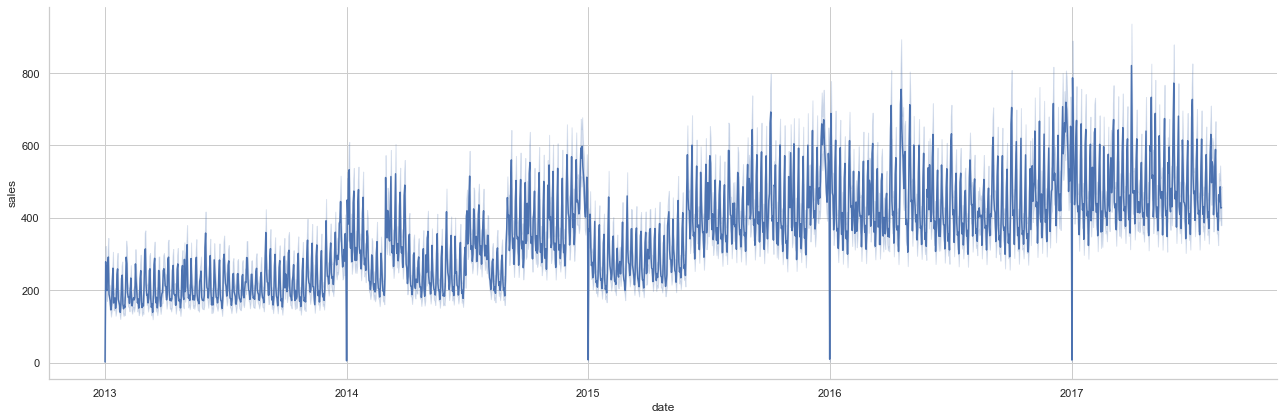

In [ ]:

# Assuming your DataFrame is train
sns.set(style="whitegrid")  # Optional: Set the style

# Adjust the figure size using height and aspect parameters
sns.relplot(data=train, x='date', y='sales', kind='line', height=6, aspect=3)#, estimator=sum)

# Show the plot
plt.show()


### Grafico II - Ventas por tienda (distribucion intercuartiles)

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x=train['store_nbr'].sort_index(), y=train['sales'], showfliers = False)
sns.set(style="white")
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.xticks(rotation=90,fontsize=8)
plt.title('Box Plots of Sales by Store Number')
plt.show()


NameError: name 'plt' is not defined

### Grafico III - Venta por familia (distribucion intercuartiles)

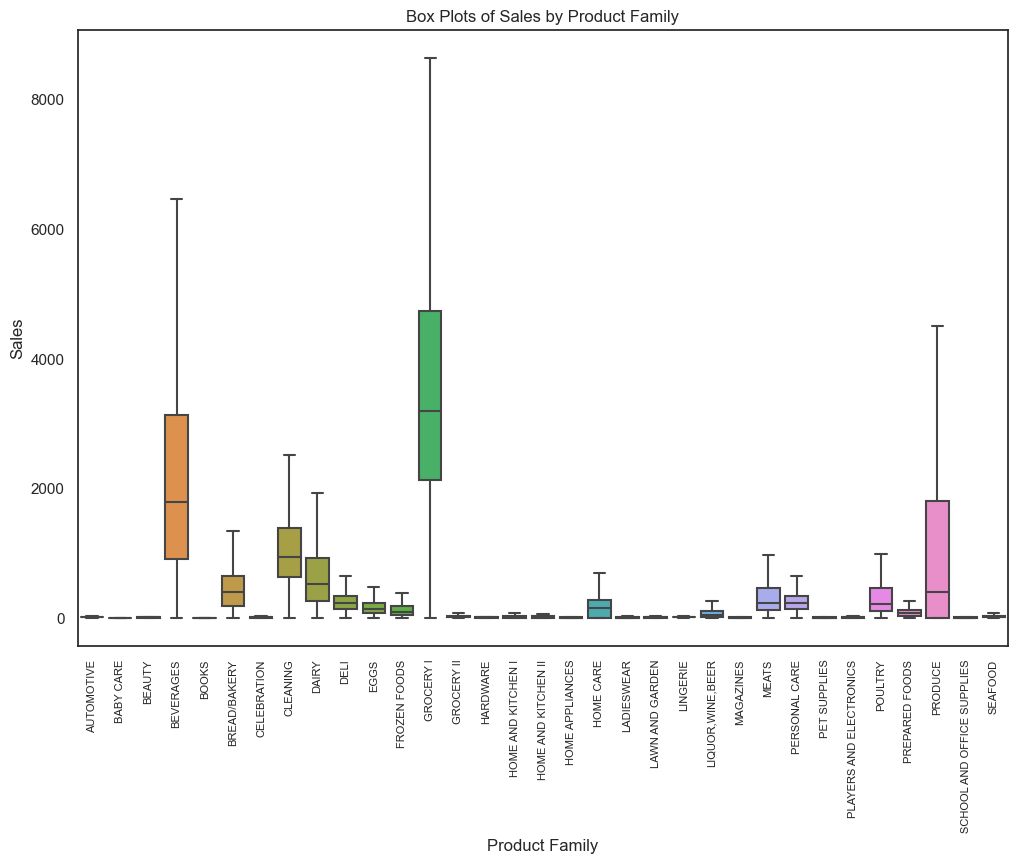

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x=train['family'], y=train['sales'], showfliers = False)
#sns.set(style="white")
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Product Family')
plt.ylabel('Sales')

plt.title('Box Plots of Sales by Product Family')

plt.show()

### Grafico IV - Ventas vs Promocion (por familia)

The following visualisation shows the positive trend between more products on promotion and sales for each family of product.

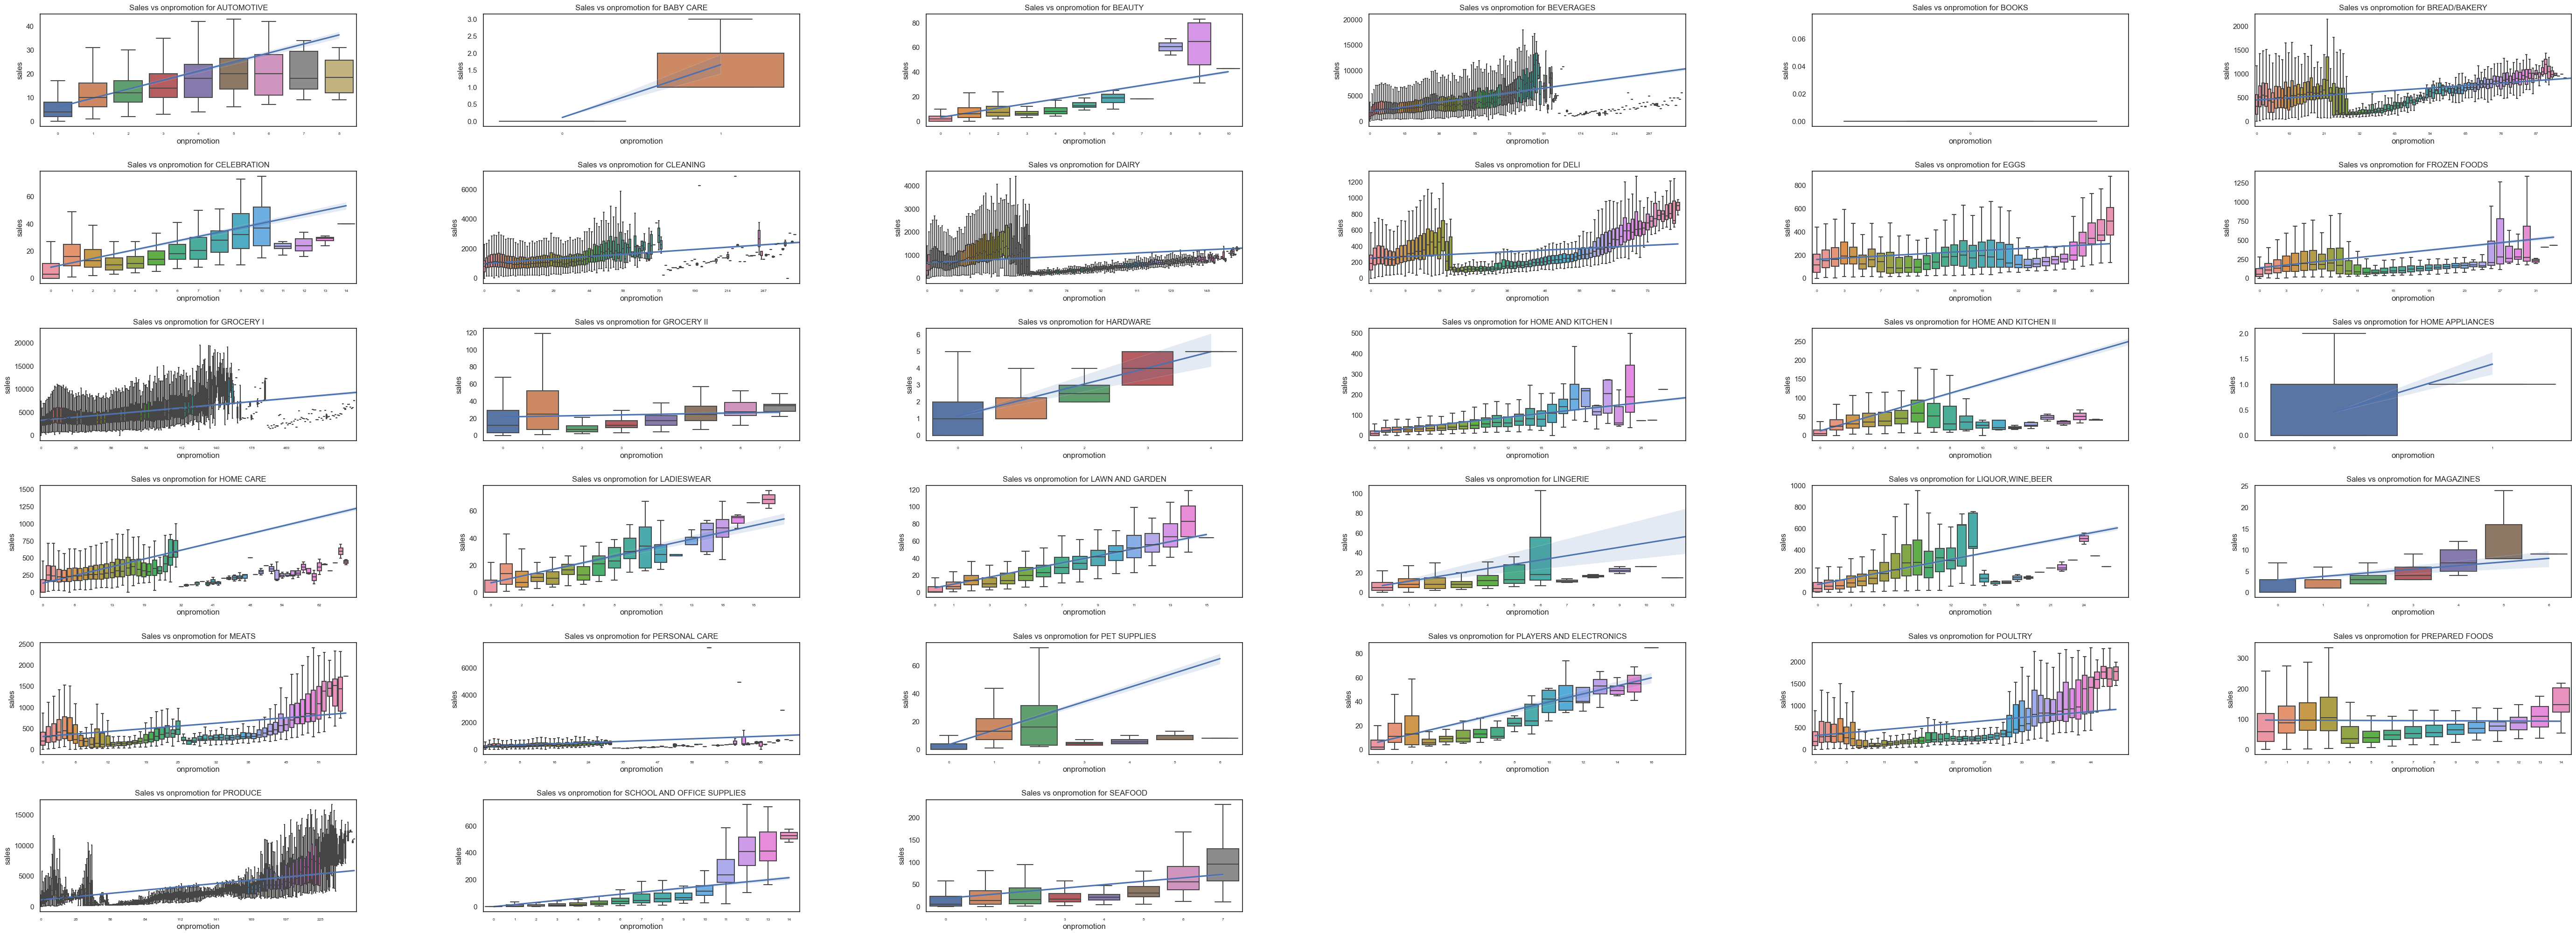

In [ ]:
product_families = train['family'].unique()

plt.figure(figsize=(70,25))

palette = sns.color_palette(None, len(product_families))


for n, family in enumerate(product_families):

    plt.subplot(6,6,n+1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    family_mask = train['family'] == family
    
    sns.boxplot(x="onpromotion", y="sales", data=train[family_mask], showfliers = False)
    sns.regplot(x="onpromotion", y="sales", data=train[family_mask], scatter=False)
    
    x_max = len(train[family_mask]['onpromotion'].unique())
    
    plt.xlim([-0.5,x_max-0.5])
    plt.xticks(fontsize=6)
    
    if x_max > 15:
        plt.xticks(np.linspace(0,x_max+1,10,dtype=int))

    
    plt.title(f'Sales vs onpromotion for {family}')

plt.show()

In the following lines we can check that this Data Set starts on 1th January 2013 despites the firs promotion is on 2014.
We should took only from 2014

In [ ]:
print(f'Start Date: {train.date.min()}')
print(f'End Date: {train.date.max()}')
print(f'Number of Days: {len(train.date.unique())}')

promotions_mask = train['onpromotion'] > 0

promoitions_min = train[promotions_mask].date.min()
promoitions_max = train[promotions_mask].date.max()

print(f'Promotions Start Date: {promoitions_min}')
print(f'Promotions End Date: {promoitions_max}')

Start Date: 2013-01-01 00:00:00
End Date: 2017-08-15 00:00:00
Number of Days: 1684
Promotions Start Date: 2014-04-01 00:00:00
Promotions End Date: 2017-08-15 00:00:00


### Train - Insights

- We have no null data to deal with
- There are 33 different types of product family, and 54 different stores
- Both variables have the same number of rows for each family/store, so we're not missing historic data for some families/stores
- We can pull out features from data such as day of week/month/year to track temporal trends
- Sales by product family varies a lot more than store number, with 'Grocery I' being the largest seller. We might be best off with model product since the variance is so high so the models can learn the particular paterns of each family
- Store number still has a strong effect on sales so will make a useful feature
- There is a strong correlation between on promotion and sales, but the trend is quite different across product families, which is another justification for product specific models
- Data ranges from between 2013-01-01 and 2017-08-15
- /!\ Promotion data is only included from 2014-04-01 though, so we might be best off only using data from here

## Feature Engineering
---

### New Features
* We will combine the DF of Train and Test.
* create lag sales features

First we will combine both DFs, Train and Test since we will be doing the variable generation task for both DataFrames.

In [4]:
# add dummy sales column to test so we can concat
test['sales'] = 0
train_test = pd.concat([train,test])

In [5]:
train_test['date'] = train_test['date'].astype('datetime64[ns]')

### LAGS

In [8]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [9]:
# use the below lags
train_lags = [16,17,20,21,22,28,35,42]

In [10]:
store_nbrs = train['store_nbr'].unique()
families = train['family'].unique()

In [11]:
# create lag features
for store in store_nbrs:

    for family in families:
    
        store_family_index = (train_test['store_nbr'] == store) & (train_test['family'] == family)
        
        
        for lag in train_lags:
    
            train_test.loc[store_family_index,f'sales-{lag}'] = train_test.loc[store_family_index,'sales'].shift(lag)

# TRANSACTIONS_DF
---
---

## Feature Engineering
---

### New Features:
* Ampliamos el DF para que contenga fechas de todo el periodo Train + Test
* Agregamos columnas de año y mes para ver autocorrelacion mensual
* Añadimos lags al dataset que utilizaremos, como hemos visto no disponemos de las transacciones del periodo test, por lo que añadimos lags

In [13]:
transactions['date'] = transactions['date'].astype('datetime64[ns]')

In [14]:
date_dummy = pd.DataFrame(pd.date_range(start=train['date'].min(), end=test['date'].max()), columns=['date'])
store_nbr_dummy = pd.DataFrame(stores, columns=['store_nbr'])

transactions_dummy = date_dummy.merge(store_nbr_dummy, how='cross')

transactions = transactions_dummy.merge(transactions, how='left', left_on=['date','store_nbr'], right_on=['date','store_nbr']).fillna(0)

### Lags

In [15]:
transaction_lags = [18,20,21,22,24,25,26,28,70,140,210,365]


for store in store_nbrs:

    store_family_index = transactions['store_nbr'] == store

    for lag in transaction_lags:

        transactions.loc[store_family_index,f'transactions-{lag}'] = transactions.loc[store_family_index,'transactions'].shift(lag)

### Eliminamos columna "Transactoins"
* La variable que vamos apoder usar en test es las ventas de x dias anteriores, la mejor medida que tendremos es la de 18 dias antes

In [16]:
transactions = transactions.drop(['transactions'], axis=1)
transactions = transactions.dropna()

# STORES
---
---

### New Features
* We will one-hot-encode the catagorical variables, but leaving the orignal columns for merging the data (will be dropped later on)

### One Hot Encoding

In [17]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

stores_encoded_array = store_encoder.fit_transform(stores[['city','state','type','cluster']])

stores = pd.concat([stores,stores_encoded_array], axis=1)

#stores = stores.drop(['type'], axis=1)

# OIL_df
---
---
-  Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

## Featuring Engineering
---

### New Features
* Need to fill na columns
* we're missing some dates from the dataset (e.g. 5th Jan 2013) so we need to create the correct data range and work from that to fill na values
* use a 5 day moving average to impute null values


In [18]:
oil['date'] = oil['date'].astype('datetime64[ns]')

In [19]:
train_start = train['date'].min()
train_end = train['date'].max()
test_start = test['date'].min()
test_end = test['date'].max()

date_range = pd.DataFrame(pd.date_range(start=train_start, end=test_end), columns=['date'])

In [20]:
oil = date_range.merge(oil, how='left', left_on=['date'], right_on=['date'])

In [21]:
# fill na columns with 5 day rolling average centred on the point
oil_na_mask = oil['dcoilwtico'].isna()

oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].rolling(5, center=True, min_periods=1).mean())

# 6. Holidays and Events

What a mess! Probably, you are confused due to the holidays and events data. It contains a lot of information inside but, don't worry. You just need to take a breathe and think! It is a meta-data so you have to split it logically and make the data useful.

What are our problems?
- Some national holidays have been transferred.
- There might be a few holidays in one day. When we merged all of data, number of rows might increase. We don't want duplicates.
- What is the scope of holidays? It can be regional or national or local. You need to split them by the scope.
- Work day issue
- Some specific events
- Creating new features etc.


End of the section, they won't be a problem anymore!


Transferred Holidays

El problema que tenemos aqui es que tenemos un dataset que modifica para su correcta implementacion para el entrenamiento.

A)Tenemos festivos que han sido transferidos lo que sería tipo Holiday y Transferred=True y ademas la propia fecha efectiva en la cual ha sido transferido, lo que es Type=Transfer.
Tiene sentido que ambas logicas sean iguales en filas, y el objetivo es quedarnos unicamente con la fecha que fue efectiva el Holiday, es decir, la segunda relación lógica, Type=Transfer, por lo que queremos quedarnos unicamente con la fecha efectiva en la que resulto un dia de "holiday" real.
Por ello vamos a hacer dos DFs y posterior limpieza

tr1 son los dias de vacaciones originales que han sido transferidos

``tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)``

tr2 es la fecha final efectiva de vacaciones

``tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)``

tr es la concatenacion de ambos DFs y no es mal que el agregado horizontal de ambos

Habiendo hecho un reset_index los ordenamos por su indice (gracias por el orden)

``tr = pd.concat([tr1,tr2], axis = 1)``


Nos quedamos con las columnas de interes que integraremos posteriormente

``tr = tr.iloc[:, [5,1,2,3,4]]``

Para finalizar este primer ajuste vamos a realizar tan solo una agregacion vertical de:
Todas los festivos que no hayan sido transferidos, es decir, fechas efectivas de Vacaciones, además eliminamos la columana "Transferred"

``holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)``

Hacemos la agregacion vertical de esto con la limpieza previa:

``holidays = holidays.append(tr).reset_index(drop = True)``

#### Additional Holidays
Lo que vamos a hacer es limpiar la informacion y colocarlo dentro de la categoria Type=Holiday

1) ``holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')``

    Eliminamos los caracteres como "-" , "+" y además con una expresion regular ('\d+',"") eliminamos todos los digitos al final del string

2) ``holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])``

    sustituimos todos los campos con Type=Addtional por Holiday

#### Bridge Holidays
Vamos a limpiar igualmente la descripcion y modificar como en el caso anterior, el type=Brdige por Holiday

1) ``holidays["description"] = holidays["description"].str.replace("Puente ", "")``

    Borramos "Puente " de la descripcion de cada fila para que aparezca unicamente la info de la festividad

2) ``holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])``

    Cambiamos el tipo Bridge por Holiday

#### Work Day Holidays
``work_day = holidays[holidays.type == "Work Day"] ``

``holidays = holidays[holidays.type != "Work Day"]``
Los dias de trabajo no los queremos

In [23]:
#holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays.date)


# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)


# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


#Split

#Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()


# Train + Test
train_test = pd.merge(train_test, stores)
train_test["store_nbr"] = train_test["store_nbr"].astype("int8")


# National Holidays & Events
train_test = pd.merge(train_test, national, how = "left")

#Regional
train_test= pd.merge(train_test, regional, how = "left", on = ["date", "state"])
# # Local
train_test = pd.merge(train_test, local, how = "left", on = ["date", "city"])
# Work Day: It will be removed when real work day colum created
train_test = pd.merge(train_test,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

train_test = pd.merge(train_test, events, how = "left")
train_test[events_cat] = train_test[events_cat].fillna(0)

# New features
train_test["holiday_national_binary"] = np.where(train_test.holiday_national.notnull(), 1, 0)
train_test["holiday_local_binary"] = np.where(train_test.holiday_local.notnull(), 1, 0)
train_test["holiday_regional_binary"] = np.where(train_test.holiday_regional.notnull(), 1, 0)

# 
train_test["national_independence"] = np.where(train_test.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
train_test["local_cantonizacio"] = np.where(train_test.holiday_local.str.contains("Cantonizacio"), 1, 0)
train_test["local_fundacion"] = np.where(train_test.holiday_local.str.contains("Fundacion"), 1, 0)
train_test["local_independencia"] = np.where(train_test.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(train_test[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
train_test = pd.concat([train_test.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = train_test.columns[train_test.columns.str.startswith("events")].tolist() + train_test.columns[train_test.columns.str.startswith("holiday")].tolist() + train_test.columns[train_test.columns.str.startswith("national")].tolist()+ train_test.columns[train_test.columns.str.startswith("local")].tolist()
train_test[he_cols] = train_test[he_cols].astype("int8")

train_test[["family", "city", "state", "type"]] = train_test[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

train_test.head(10)

C:\Users\Javier\AppData\Local\Temp\ipykernel_11280\3554847841.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holidays = holidays.append(tr).reset_index(drop = True)
C:\Users\Javier\AppData\Local\Temp\ipykernel_11280\3554847841.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
C:\Users\Javier\AppData\Local\Temp\ipykernel_11280\3554847841.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')


,id,date,store_nbr,family,sales,onpromotion,sales-16,sales-17,sales-20,sales-21,sales-22,sales-28,sales-35,sales-42,city,state,type,cluster,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Azuay,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,IsWorkDay,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

**Let's apply an AB test to Events and Holidays features. Are they statistically significant? Also it can be a good way for first feature selection.**

- *H0: The sales are equal* **(M1 = M2)**
- *H1: The sales are not equal* **(M1 != M2)**

In [24]:
# def AB_Test(dataframe, group, target):
    
#     # Packages
#     from scipy.stats import shapiro
#     import scipy.stats as stats
    
#     # Split A/B
#     groupA = dataframe[dataframe[group] == 1][target]
#     groupB = dataframe[dataframe[group] == 0][target]
    
#     # Assumption: Normality
#     ntA = shapiro(groupA)[1] < 0.05
#     ntB = shapiro(groupB)[1] < 0.05
#     # H0: Distribution is Normal! - False
#     # H1: Distribution is not Normal! - True
    
#     if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
#         # Parametric Test
#         # Assumption: Homogeneity of variances
#         leveneTest = stats.levene(groupA, groupB)[1] < 0.05
#         # H0: Homogeneity: False
#         # H1: Heterogeneous: True
        
#         if leveneTest == False:
#             # Homogeneity
#             ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
#             # H0: M1 == M2 - False
#             # H1: M1 != M2 - True
#         else:
#             # Heterogeneous
#             ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
#             # H0: M1 == M2 - False
#             # H1: M1 != M2 - True
#     else:
#         # Non-Parametric Test
#         ttest = stats.mannwhitneyu(groupA, groupB)[1] 
#         # H0: M1 == M2 - False
#         # H1: M1 != M2 - True
        
#     # Result
#     temp = pd.DataFrame({
#         "AB Hypothesis":[ttest < 0.05], 
#         "p-value":[ttest]
#     })
#     temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
#     temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
#     temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
#     temp["Feature"] = group
#     temp["GroupA_mean"] = groupA.mean()
#     temp["GroupB_mean"] = groupB.mean()
#     temp["GroupA_median"] = groupA.median()
#     temp["GroupB_median"] = groupB.median()
    
#     # Columns
#     if (ntA == False) & (ntB == False):
#         temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
#         temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
#     else:
#         temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    
#     # Print Hypothesis
#     # print("# A/B Testing Hypothesis")
#     # print("H0: A == B")
#     # print("H1: A != B", "\n")
    
#     return temp
    
# # Apply A/B Testing
# he_cols = train_test.columns[train_test.columns.str.startswith("events")].tolist() + train_test.columns[train_test.columns.str.startswith("holiday")].tolist() + train_test.columns[train_test.columns.str.startswith("national")].tolist()+ train_test.columns[train_test.columns.str.startswith("local")].tolist()
# ab = []
# for i in he_cols:
#     ab.append(AB_Test(dataframe=train_test[train_test.sales.notnull()], group = i, target = "sales"))
# ab = pd.concat(ab)
# ab

In [25]:
# fails=ab[ab["AB Hypothesis"]=="Fail to Reject H0"]["Feature"].to_list()
# fails

In [26]:
# columns_to_keep = [col for col in train_test.columns if col not in fails]

# train_test = train_test[columns_to_keep]

In [27]:
# categorical_columns = train_test.select_dtypes(include=['category']).columns
# print(train_test[categorical_columns])

# 7. Time Related Features

How many features can you create from only date column? I'm sharing an example of time related features. You can expand the features with your imagination or your needs. 

In [28]:
# Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
train_test = create_date_features(train_test)




# Workday column
train_test["workday"] = np.where((train_test.holiday_national_binary == 1) | (train_test.holiday_local_binary==1) | (train_test.holiday_regional_binary==1) | (train_test['day_of_week'].isin([6,7])), 0, 1)
train_test["workday"] = pd.Series(np.where(train_test.IsWorkDay.notnull(), 1, train_test["workday"])).astype("int8")
train_test.drop("IsWorkDay", axis = 1, inplace = True)

# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
train_test["wageday"] = pd.Series(np.where((train_test['is_month_end'] == 1) | (train_test["day_of_month"] == 15), 1, 0)).astype("int8")

train_test.head(15)

C:\Users\Javier\AppData\Local\Temp\ipykernel_11280\1520388946.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")


,id,date,store_nbr,family,sales,onpromotion,sales-16,sales-17,sales-20,sales-21,sales-22,sales-28,sales-35,sales-42,city,state,type,cluster,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Azuay,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,workday,wageday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Zero Forecasting

Some stores don't sell some product families. In the following code, you can see which products aren't sold in which stores. It isn't difficult to forecast them next 15 days. Their forecasts must be 0 next 15 days.

I will remove them from the data and create a new data frame for product families which never sell. Then, when we are at submission part, I will combine that data frame with our predictions.

In [29]:
c = train_test.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


In [30]:
exe=pd.merge(c,test,on=['store_nbr','family'])
id_zero=exe["id"]

Our first forecasting is done! You don't need the machine learning or deep learning or another things for these time series because we had some simple time series.



# ENTRENAMIENTO & SUMISION

## Concatenate all DataFrames for Training


In [31]:
print(train_test.shape)
print(transactions.shape)
print(stores.shape)
print(oil.shape)

(3029400, 146)
(72306, 14)
(54, 65)
(1704, 2)


In [32]:
#  merge train, oil & stores
print(train_test.shape)
all_concat = train_test.merge(oil, how='left', on='date')
print(all_concat.shape)
all_concat = all_concat.merge(stores, left_on=['store_nbr'], right_on=['store_nbr'], suffixes = ['_store', '_holiday'])
print(all_concat.shape)
all_concat = all_concat.merge(transactions, left_on=['date','store_nbr'], right_on=['date','store_nbr'])
# print(train_test.shape) # should drop due to removing date that can't have lags

(3029400, 146)


(3029400, 147)
(3029400, 211)


## Final Adjustments
* remove date from disaster period since data isn't representative (2016-04-16)
* fill na data (from holiday columns) with 0 where no merge was found
* set index to date column

In [33]:
## look at total sales by day 3 months before and after period to see when level were back to normal
period_mask = (all_concat['date'].dt.date >= datetime.date(2016,1,15)) & (all_concat['date'].dt.date < datetime.date(2016,12,15))

all_concat_disaster = all_concat[period_mask]

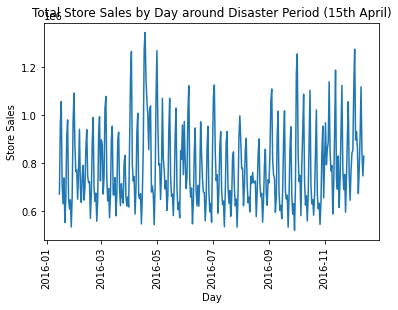

In [34]:
## volumes seem to normalise within approx 1 month - remove data from that period
disater_period_sales = all_concat_disaster.groupby('date')['sales'].sum()

plt.plot(disater_period_sales)
plt.ylabel('Store Sales')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.title('Total Store Sales by Day around Disaster Period (15th April)')
plt.show()

* Hay una epoca de 4 semanas desde el terremoto en 16 de Abril de 2016 que no es representativo - lo borramos

Para ello hacemos un filtro en donde hacemos que sea menor de la fecha del terremoto y mayor a la misma fecha + 4 semanas

In [35]:
period_mask = (
    (all_concat['date'].dt.date < datetime.date(2016, 4, 16)) |
    (all_concat['date'].dt.date >= datetime.date(2016, 4, 16) + datetime.timedelta(weeks=4))
)

all_concat = all_concat[period_mask]

In [36]:
categorical_columns = all_concat.select_dtypes(include=['category']).columns
print(all_concat[categorical_columns])

                             family city_store state_store type_store
0                        AUTOMOTIVE      Quito   Pichincha          D
1                         BABY CARE      Quito   Pichincha          D
2                            BEAUTY      Quito   Pichincha          D
3                         BEVERAGES      Quito   Pichincha          D
4                             BOOKS      Quito   Pichincha          D
...                             ...        ...         ...        ...
2380747                     POULTRY      Quito   Pichincha          B
2380748              PREPARED FOODS      Quito   Pichincha          B
2380749                     PRODUCE      Quito   Pichincha          B
2380750  SCHOOL AND OFFICE SUPPLIES      Quito   Pichincha          B
2380751                     SEAFOOD      Quito   Pichincha          B

[2330856 rows x 4 columns]


In [37]:
all_concat.drop(columns=['city_store','state_store','type_store'],inplace=True)

In [38]:
all_concat.drop(columns=['city_holiday','state_holiday','type_holiday'],inplace=True)

Quitamos la columna DATE y la dejamos como indice

In [40]:
all_concat.index = all_concat['date']
all_concat = all_concat.drop(['date'], axis=1)

In [41]:
all_concat_copy=all_concat.copy()
all_concat.shape

(2330856, 216)

In [42]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

all_concat_encoded_array = store_encoder.fit_transform(all_concat[['store_nbr']])

all_concat = pd.concat([all_concat,all_concat_encoded_array], axis=1)

#all_concat = all_concat.drop(['store_nbr','city','state','cluster'], axis=1)

# store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

# train_test_encoded_array = store_encoder.fit_transform(train_test[['store_nbr']])

# train_test = pd.concat([train_test,train_test_encoded_array], axis=1)

# train_test = train_test.drop(['store_nbr'], axis=1)

Una vez añadido el dataframe de holidays, podremos quitar los predictores de city y state, ``No antes por que lo necesitamos para el merge`` 

In [43]:
all_concat.drop(columns=['cluster_store'],inplace=True)

In [44]:
print(all_concat.shape)
all_concat.head()

(2330856, 269)


,id,store_nbr,family,sales,onpromotion,sales-16,sales-17,sales-20,sales-21,sales-22,sales-28,sales-35,sales-42,city_Ambato_store,city_Babahoyo_store,city_Cayambe_store,city_Cuenca_store,city_Daule_store,city_El Carmen_store,city_Esmeraldas_store,city_Guaranda_store,city_Guayaquil_store,city_Ibarra_store,city_Latacunga_store,city_Libertad_store,city_Loja_store,city_Machala_store,city_Manta_store,city_Playas_store,city_Puyo_store,city_Quevedo_store,city_Quito_store,city_Riobamba_store,city_Salinas_store,city_Santo Domingo_store,state_Azuay_store,state_Bolivar_store,state_Chimborazo_store,state_Cotopaxi_store,state_El Oro_store,state_Esmeraldas_store,state_Guayas_store,state_Imbabura_store,state_Loja_store,state_Los Rios_store,state_Manabi_store,state_Pastaza_store,state_Pichincha_store,state_Santa Elena_store,state_Santo Domingo de los Tsachilas_store,state_Tungurahua_store,type_A_store,type_B_store,type_C_store,type_D_store,type_E_store,cluster_1_store,cluster_2_store,cluster_3_store,cluster_4_store,cluster_5_store,cluster_6_store,cluster_7_store,cluster_8_store,cluster_9_store,cluster_10_store,cluster_11_store,cluster_12_store,cluster_13_store,cluster_14_store,cluster_15_store,cluster_16_store,cluster_17_store,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,workday,wageday,dcoilwtico,cluster_holiday,city_Ambato_holiday,city_Babahoyo_holiday,city_Cayambe_holiday,city_Cuenca_holiday,city_Daule_holiday,city_El Carmen_holiday,city_Esmeraldas_holiday,city_Guaranda_holiday,city_Guayaquil_holiday,city_Ibarra_holiday,city_Latacunga_holiday,city_Libertad_holiday,city_Loja_holiday,city_Machala_holiday,city_Manta_holiday,city_Playas_holiday,city_Puyo_holiday,city_Quevedo_holiday,city_Quito_holiday,city_Riobamba_holiday,city_Salinas_holiday,city_Santo Domingo_holiday,state_Azuay_holiday,state_Bolivar_holiday,state_Chimborazo_holiday,state_Cotopaxi_holiday,state_El Oro_holiday,state_Esmeraldas_holiday,state_Guayas_holiday,state_Imbabura_holiday,state_Loja_holiday,state_Los Rios_holiday,state_Manabi_holiday,state_Pastaza_holiday,state_Pichincha_holiday,state_Santa Elena_holiday,state_Santo Domingo de los Tsachilas_holiday,state_Tungurahua_holiday,type

## Split into Test,Train and Submissions Sets

Para separar ahora entre entrenamiento y test, ``vamos a utilizar los ID`` maximas y minimas de los DFs de Train y Test dados como informacion

In [45]:
train_index_min = train['id'].min()
train_index_max = train['id'].max()
test_index_min = test['id'].min()
test_index_max = test['id'].max()

In [46]:
X_train = all_concat[(all_concat['id'] >=train_index_min) & (all_concat['id'] <= train_index_max)]
X_submission = all_concat[(all_concat['id'] >=test_index_min) & (all_concat['id'] <= test_index_max)]

In [47]:
y_train = X_train['sales'].copy()
X_train = X_train.drop(['sales'], axis=1)
X_submission = X_submission.drop(['sales'], axis=1)

In [48]:
X_train_id = X_train['id']
X_submission_id = X_submission['id']

X_train = X_train.drop(['id'], axis=1)
X_submission = X_submission.drop(['id'], axis=1)

In [49]:
X_test = X_train.loc['2017-08-01':'2017-08-15',:]
X_train = X_train.loc['2017-01-01':'2017-07-31',:]

In [50]:
y_test = y_train.loc['2017-08-01':'2017-08-15']
y_train = y_train.loc['2017-01-01':'2017-07-31']

In [52]:
gc.collect()

2674

## Train Model - Model Per Product
* Train and store down model for each product family

In [55]:
product_families = train['family'].unique()


# train model & store accurcies per product familu
y_pred = y_test.copy()
y_pred[:] = 0

family_models = {}
product_accuracy = np.zeros(len(product_families))

for n, p_f in enumerate(product_families):
    
    # train model
    model = LGBMRegressor()
        
    train_family_mask = X_train['family'] == p_f
    
    model.fit(X_train[train_family_mask].drop('family', axis=1), y_train[train_family_mask])
    
    
    # test model
    test_family_mask = X_test['family'] == p_f
    
    y_pred[test_family_mask] = model.predict(X_test[test_family_mask].drop('family', axis=1))
    
    y_pred[y_pred < 0] = 0
    
    # calculate msle
    msle = mean_squared_log_error(y_test[test_family_mask], y_pred[test_family_mask])
    product_accuracy[n] = msle
    
    # save model
    family_models[p_f] = model

    print(f'Trained Model for Family {p_f} with a MSLE of {msle}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 226
[LightGBM] [Info] Start training from score 7.425227
Trained Model for Family AUTOMOTIVE with a MSLE of 0.28407610153183044
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 225
[LightGB

In [ ]:
msle = mean_squared_log_error(y_test, y_pred)

print(f'Overall Mean Squared Log Error on Test set is : {msle:.4f}')

Overall Mean Squared Log Error on Test set is : 0.1764


## Review Results
* View predicitons on test set vs actual test set data
* Check MSLE across stores and product familys to check for outliers
* sense check example preditions to submission set

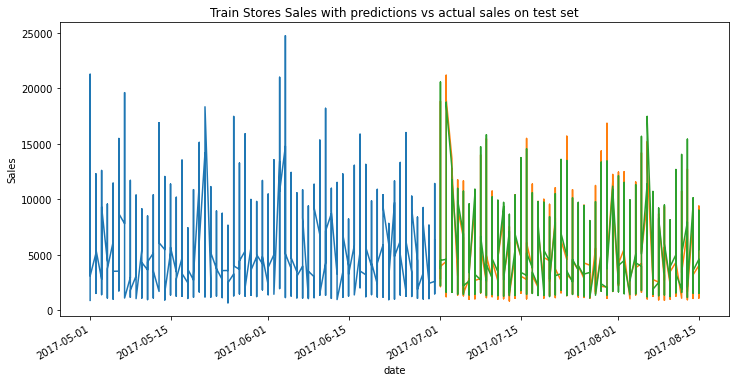

In [ ]:
# look at predictions for books to sense check accuracy
train_family_mask = X_train['family'] == 'GROCERY I'
test_family_mask = X_test['family'] == 'GROCERY I'

plt.figure(figsize=(12,6))
y_train[train_family_mask].loc['2017-05-01':].plot()
y_test[test_family_mask].plot()
y_pred[test_family_mask].plot()

plt.title('Train Stores Sales with predictions vs actual sales on test set')
plt.ylabel('Sales')

plt.show()

### Check MSLE across stores and product familys to check for outliers

In [ ]:
store_accuracy = np.zeros(len(store_nbrs))

for n, store in enumerate(store_nbrs):
    
    store_mask = X_test['store_nbr_'+str(store)] == 1
    
    msle = mean_squared_log_error(y_test[store_mask], y_pred[store_mask])
    
    store_accuracy[n] = msle

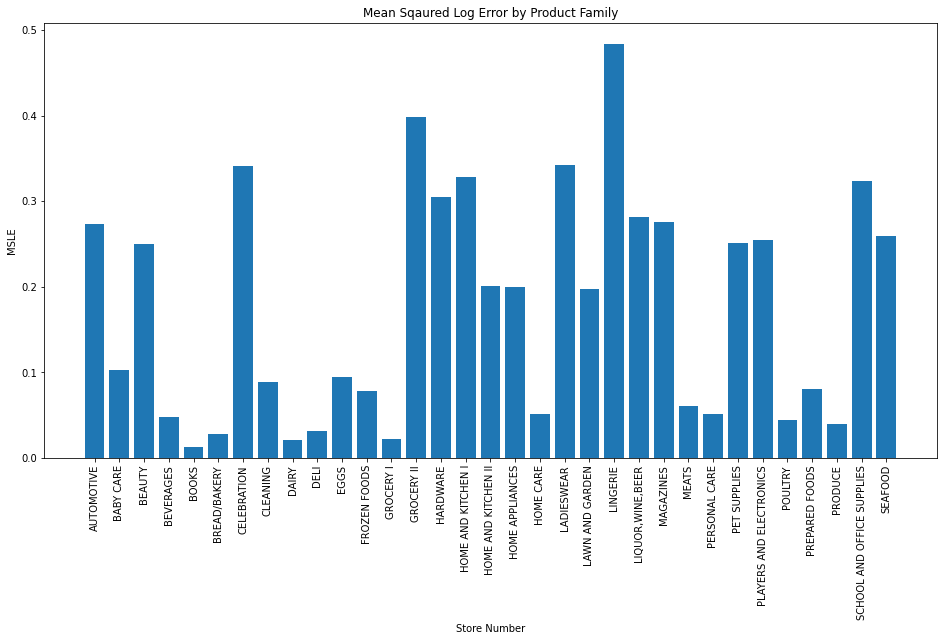

In [ ]:
plt.figure(figsize=(16,8))

plt.bar(product_families,product_accuracy)

plt.xticks(rotation=90)

plt.xlabel('Store Number')
plt.ylabel('MSLE')

plt.title('Mean Sqaured Log Error by Product Family')
plt.show()

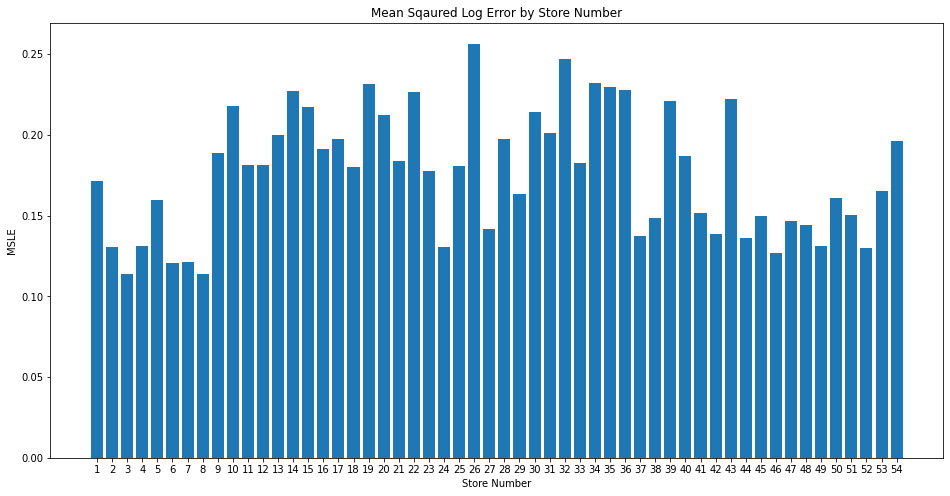

In [ ]:
plt.figure(figsize=(16,8))

plt.bar(store_nbrs,store_accuracy)

plt.xticks(store_nbrs)

plt.xlabel('Store Number')
plt.ylabel('MSLE')

plt.title('Mean Sqaured Log Error by Store Number')
plt.show()

### Make Predictions

In [ ]:
# functionable
y_submission_pred= pd.Series(data=0, index=X_submission.index)

for p_f in product_families:
    
    # train model
    model = family_models[p_f]    
    
    # make predictions
    submission_family_mask = X_submission['family'] == p_f
    
    y_submission_pred[submission_family_mask] = model.predict(X_submission[submission_family_mask].drop('family', axis=1))
        
    print(f'Made predictions of Family {p_f}')
    
y_submission_pred[y_submission_pred < 0] = 0
    

Made predictions of Family AUTOMOTIVE
Made predictions of Family BABY CARE
Made predictions of Family BEAUTY
Made predictions of Family BEVERAGES
Made predictions of Family BOOKS
Made predictions of Family BREAD/BAKERY
Made predictions of Family CELEBRATION
Made predictions of Family CLEANING
Made predictions of Family DAIRY
Made predictions of Family DELI
Made predictions of Family EGGS
Made predictions of Family FROZEN FOODS
Made predictions of Family GROCERY I
Made predictions of Family GROCERY II
Made predictions of Family HARDWARE
Made predictions of Family HOME AND KITCHEN I
Made predictions of Family HOME AND KITCHEN II
Made predictions of Family HOME APPLIANCES
Made predictions of Family HOME CARE
Made predictions of Family LADIESWEAR
Made predictions of Family LAWN AND GARDEN
Made predictions of Family LINGERIE
Made predictions of Family LIQUOR,WINE,BEER
Made predictions of Family MAGAZINES
Made predictions of Family MEATS
Made predictions of Family PERSONAL CARE
Made predicti

In [ ]:
# Obtén las columnas directamente si solo tienes una columna en cada DataFrame
sales_column_y = y_submission_pred.squeeze()  # Accede directamente a la única columna
sales_column_X = X_submission_id.squeeze()    # Accede directamente a la única columna

# Crea un nuevo DataFrame con las columnas 'id' y 'sales'
new_df = pd.DataFrame({'id': sales_column_X.astype(int), 'sales': sales_column_y.astype(float)})

# Muestra el nuevo DataFrame
print(new_df)


                 id        sales
date                            
2017-08-16  3000888     5.167225
2017-08-16  3000889     0.045504
2017-08-16  3000890     4.361419
2017-08-16  3000891  2232.700621
2017-08-16  3000892     0.162779
...             ...          ...
2017-08-31  3029395   341.315387
2017-08-31  3029396   102.618579
2017-08-31  3029397  1160.662538
2017-08-31  3029398   143.558385
2017-08-31  3029399    14.729170

[28512 rows x 2 columns]


# Incluimos los valores de prediccion igual a 0

In [ ]:
new_df.loc[new_df['id'].isin(id_zero),'sales']=0

In [ ]:
new_df.to_csv('store_sales_submission_6.csv',index = False)